# Flux analysis, homocysteine tracing

In [1]:
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from scipy.stats import norm
import sys

In [2]:
#  path to simpleflux package 
sys.path.append('C:/code/python/simpleflux/src')
from simpleflux.model import FluxModel, FluxState
from simpleflux.modelstate import ModelState
from simpleflux.fitting import ModelFit

In [3]:
input_data_path = Path('00_input_data')
heavy_fractions_path = Path('02_heavy_fractions')
results_path = Path('04_hcys_flux_analysis')

In [4]:
# make matplotlib use TrueType fonts for PDF export
matplotlib.rcParams['pdf.fonttype'] = 42

In [5]:
np.set_printoptions(precision=3, suppress=True)

## Define functions

In [6]:
def prepend_index_level(df: pd.DataFrame, values, name: str) -> pd.DataFrame:
    return df.assign(**{name: values}).set_index(name, append=True).swaplevel()

In [7]:
def plot_model_fit(flux_model: FluxModel, x_predicted: pd.DataFrame,
                   heavy_fractions: pd.DataFrame, use_log_scale: bool = False) -> None:
    y_axis_margin = 0.05
    fig, axs = plt.subplots(ncols=len(flux_model.metabolites), figsize=(15,3))
    for i, metabolite in enumerate(flux_model.metabolites):
        axs[i].plot(x_predicted[metabolite])
        if metabolite in heavy_fractions.columns:
            axs[i].plot(heavy_fractions[metabolite], '.')
        axs[i].set_ylim(-y_axis_margin, 1 + y_axis_margin)
        axs[i].set_title(metabolite)
        if use_log_scale:
            axs[i].set_xscale('log')
            axs[i].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        axs[i].set_xticks(heavy_fractions.index)

In [8]:
def plot_file_name(cell_type: str, log_scale: bool) -> str:
    plot_name = 'hcys_fitted_data'
    if log_scale:
        scale_suffix = 'logscale'
    else:
        scale_suffix = 'linscale'
    return "_".join([cell_type, plot_name, scale_suffix]) + '.pdf'

In [9]:
def confidence_intervals_table(model_fit: ModelFit, ci_level: float) -> pd.DataFrame:
    fitted_net_fluxes = model_fit.model_state.flux_state.net_fluxes
    net_flux_std_err = model_fit.fitted_fluxes_std_err()
    ci_scale_factor = norm.isf((1 -ci_level)/2)
    return pd.DataFrame(
        {
            'net': fitted_net_fluxes,
            'std err': net_flux_std_err,
            'ci_half-width': net_flux_std_err*ci_scale_factor,
            'ci_lower': fitted_net_fluxes - net_flux_std_err*ci_scale_factor,
            'ci_upper': fitted_net_fluxes + net_flux_std_err*ci_scale_factor,
        },
        index=pd.Index(flux_model.reactions, name='reaction')
    )

## Define model

### Stoichiometry

In [10]:
stoichiometry = defaultdict(int, {
    ('HCYS_IN', 'hcys'): 1,
    ('PROT_SYNTH', 'met'): -1, ('PROT_SYNTH', 'metp'): 1, 
    ('AHCY', 'sah'): -1, ('AHCY', 'hcys'): 1, 
    ('METS', 'hcys'): -1, ('METS', 'met'): 1, 
    ('MAT', 'met'): -1, ('MAT', 'sam'): 1, 
    ('SAM_METH', 'sam'): -1, ('SAM_METH', 'sah'): 1, 
    ('CYSTS', 'hcys'): -1, ('CYSTS', 'cyst'): 1,
    ('CYSTL', 'cyst'): -1, ('CYSTL', 'akb'): 1,
    ('MET_OUT', 'met'): -1,
    ('PROT_OUT', 'metp'): -1,
    ('AKB_OUT', 'akb'): -1,
})

reversible_reactions = [
    'HCYS_IN',
    'PROT_SYNTH',
    'AHCY',
    'CYSTL',
]

free_reactions = ['CYSTS', 'METS', 'PROT_OUT', 'SAM_METH']

flux_model = FluxModel(stoichiometry, reversible_reactions, free_reactions)

In [11]:
flux_model.get_stoichiometry_df()

,AHCY,AKB_OUT,CYSTL,CYSTS,HCYS_IN,MAT,METS,MET_OUT,PROT_OUT,PROT_SYNTH,SAM_METH
akb,0,-1,1,0,0,0,0,0,0,0,0
cyst,0,0,-1,1,0,0,0,0,0,0,0
hcys,1,0,0,-1,1,0,-1,0,0,0,0
met,0,0,0,0,0,-1,1,-1,0,-1,0
metp,0,0,0,0,0,0,0,0,-1,1,0
sah,-1,0,0,0,0,0,0,0,0,0,1
sam,0,0,0,0,0,1,0,0,0,0,-1


## D4-homocysteine tracing

### Pool sizes

Estimated intracellular concentrations in uM

NOTE: we might leave out akb here

In [12]:
pool_size_data = pd.read_csv(input_data_path / 'D4-hcys_concentrations.csv', sep=';', index_col=[0, 1])
pool_size_data

mean  std_dev
cell_type metabolite                  
BJ-TERT   hcys          127.1     5.41
          met             2.7     0.23
          sam            15.8     5.74
          sah             5.3     0.08
          cyst           34.1     4.89
          metp        23500.0  2350.00
          akb          1000.0  1000.00
BJ-RAS    hcys          205.0     8.70
          met             2.3     0.12
          sam            28.8     6.11
          sah             7.0     0.18
          cyst           19.0     1.07
          metp        23500.0  2350.00
          akb          1000.0  1000.00

### Measured fluxes

Measured fluxes (pmol / h * uL cells = uM / h).

In [13]:
measured_fluxes = pd.read_csv(input_data_path / 'D4-hcys_measured_fluxes.csv', sep=';', index_col=[0, 1])
measured_fluxes

mean  std_dev
cell_type flux                    
BJ-TERT   PROT_OUT  337.0    74.00
          MET_OUT    12.0     4.00
BJ-RAS    PROT_OUT   49.6     4.96
          MET_OUT     3.0     1.00

### Heavy fractions

In [14]:
# drop methionine data (not reliable)
heavy_fractions = pd.read_csv(heavy_fractions_path / 'D4-hcys_heavy_fractions.csv', index_col=[0, 1, 2])\
    .drop('met', axis=1)
# use time in hours
heavy_fractions.index = heavy_fractions.index\
    .set_levels(heavy_fractions.index.levels[1].astype('float64') / 60, level=1)\
    .rename(['cell_type', 'time_hours', 'replicate_nr'])
heavy_fractions.head(5)

cyst      hcys       sah       sam
cell_type time_hours replicate_nr                                            
BJ-RAS    0.083333   1            -4.593566e-07  0.973315  0.090056  0.058944
                     2            -4.593566e-07  0.976601  0.097586  0.057966
          0.250000   1            -4.593566e-07  0.976907  0.144331  0.102804
                     2            -4.593566e-07  0.983596  0.165651  0.116804
          0.500000   1             3.206148e-02  0.972768  0.222937  0.192457

In [15]:
heavy_fraction_mean = heavy_fractions.groupby(level=[0, 1]).mean()
heavy_fraction_mean

cyst      hcys       sah       sam
cell_type time_hours                                            
BJ-RAS    0.083333   -4.593566e-07  0.974958  0.093821  0.058455
          0.250000   -4.593566e-07  0.980252  0.154991  0.109804
          0.500000    2.473517e-02  0.974808  0.257078  0.203058
          1.000000    5.208494e-02  0.966340  0.362543  0.318602
          5.000000    4.347830e-01  0.966880  0.544890  0.527086
          24.000000   8.277716e-01  1.000000  0.720305  0.656083
BJ-TERT   0.083333   -4.593566e-07  0.966341  0.110916  0.089081
          0.250000   -4.593566e-07  0.983303  0.221635  0.169860
          0.500000    1.301532e-02  0.976673  0.349556  0.204238
          1.000000    3.159986e-02  0.964477  0.462107  0.273886
          5.000000    3.603861e-01  1.000000  0.644316  0.412310
          24.000000   8.977940e-01  1.000000  0.638767  0.512422

In [73]:
min_std_dev = 0.02
heavy_fraction_sd = np.maximum(heavy_fractions.groupby(level=[0, 1]).std(), min_std_dev)
heavy_fraction_sd

cyst      hcys       sah       sam
cell_type time_hours                                        
BJ-RAS    0.083333    0.020000  0.020000  0.020000  0.020000
          0.250000    0.020000  0.020000  0.020000  0.020000
          0.500000    0.020000  0.020000  0.048283  0.020000
          1.000000    0.020000  0.020000  0.033905  0.020000
          5.000000    0.020000  0.020000  0.020000  0.020000
          24.000000   0.020000  0.020000  0.020000  0.020417
BJ-TERT   0.083333    0.020000  0.020000  0.021059  0.020000
          0.250000    0.020000  0.023614  0.020000  0.020000
          0.500000    0.020000  0.020000  0.020000  0.020000
          1.000000    0.020000  0.020000  0.024549  0.031353
          5.000000    0.026899  0.020000  0.021608  0.020000
          24.000000   0.020000  0.020000  0.020000  0.020000

### Initial flux state

In [91]:
init_flux_state = FluxState.from_dict(
    flux_model,
    free_fluxes={
        'CYSTS' : 7,
        'METS': 350,
        'SAM_METH': 30,
        'PROT_OUT': 500,
    },
    exchanges={
        'HCYS_IN' : 0.9,
        'PROT_SYNTH': 0.4,
        'AHCY': 0.9,
        'CYSTL': 0.4,
    }
)

In [89]:
initial_state = ModelState(
    model=flux_model,
    flux_state=init_flux_state,
    concentrations=pool_size_data.loc['BJ-TERT'].loc[flux_model.metabolites, 'mean'].to_numpy(),
    medium_mi={'HCYS_IN': 1.0}
)

In [90]:
flux_model.get_flux_table(init_flux_state)

,net_flux,fwd_flux,rev_flux
AHCY,30.0,1500.000000,1470.000000
AKB_OUT,7.0,7.000000,0.000000
CYSTL,7.0,11.666667,4.666667
CYSTS,7.0,7.000000,0.000000
HCYS_IN,327.0,3270.000000,2943.000000
MAT,30.0,30.000000,0.000000
METS,350.0,350.000000,0.000000
MET_OUT,-180.0,-180.000000,-0.000000
PROT_OUT,500.0,500.000000,0.000000
PROT_SYNTH,500.0,833.333333,333.333333


### Fit model

In [77]:
cell_types = ['BJ-TERT', 'BJ-RAS']

In [78]:
model_fits = {
    cell_type: ModelFit(
        initial_state,
        measured_mi = heavy_fraction_mean.loc[cell_type],
        measured_mi_std_dev = heavy_fraction_sd.loc[cell_type],
        measured_fluxes=measured_fluxes.loc[cell_type],
        measured_conc=pool_size_data.loc[cell_type]
    )
    for cell_type in cell_types
}

Initial residuals

In [79]:
[model_fits[cell_type].model_residual() for cell_type in cell_types]

[array([ -0.488,   4.998, -28.082,   2.399,  -2.061,  -0.279, -34.144,
          0.305,  -3.682,  -0.834, -28.657,  -4.543,  -6.763,  -1.512,
        -19.384,  -4.99 ,  -4.85 ,   0.206, -14.195,  -6.759,  12.65 ,
          0.146, -16.325,  -8.333,  -2.203,  48.   ,   0.   ,   0.   ,
          0.   ,   0.   ,   0.   ,   0.   ,   0.   ]),
 array([ -0.488,   5.428, -30.423,   0.868,  -2.061,  -0.482, -37.476,
         -2.698,  -3.096,  -0.927, -13.786,  -4.602,  -5.738,  -1.419,
        -16.971,  -5.587,  -2.803,  -1.45 , -20.307,  -1.02 ,   9.149,
          0.146, -12.248,  -1.126, -90.806, 183.   ,   8.954,  -3.333,
          2.128,   9.444, -14.112,   0.   ,   0.   ])]

Fit models

In [80]:
for cell_type in cell_types:
    model_fits[cell_type].fit()

In [92]:
model_fits['BJ-TERT'].minimizer_result.params

name,value,standard error,relative error,initial value,min,max,vary
CYSTS,3.01336803,0.82248194,(27.29%),7,0.01000000,1000.00000,True
METS,266.655387,75.2575748,(28.22%),350,0.01000000,1000.00000,True
PROT_OUT,238.137283,74.9619044,(31.48%),500,0.01000000,1000.00000,True
SAM_METH,16.6878986,5.47500948,(32.81%),30,0.01000000,1000.00000,True
AHCY_EX,0.29993646,0.04300031,(14.34%),0.9,0.00000000,0.99900000,True
CYSTL_EX,4.2968e-07,0.08649213,(20129306.78%),0.4,0.00000000,0.99900000,True
HCYS_IN_EX,0.96052120,0.02203458,(2.29%),0.9,0.00000000,0.99900000,True
PROT_SYNTH_EX,0.63796600,0.02714496,(4.25%),0.4,0.00000000,0.99900000,True
akb,999.999824,1579.44100,(157.94%),1000.0,100.000000,10000.0000,True
cyst,34.0973835,7.72346646,(22.65%),34.1,3.41000000,341.000000,True


In [81]:
flux_model.get_flux_table(model_fits['BJ-TERT'].model_state.flux_state)

,net_flux,fwd_flux,rev_flux
AHCY,16.687899,23.837691,7.149793
AKB_OUT,3.013368,3.013368,0.000000
CYSTL,3.013368,3.013369,0.000001
CYSTS,3.013368,3.013368,0.000000
HCYS_IN,252.980856,6408.018093,6155.037237
MAT,16.687899,16.687899,0.000000
METS,266.655387,266.655387,0.000000
MET_OUT,11.830205,11.830205,0.000000
PROT_OUT,238.137283,238.137283,0.000000
PROT_SYNTH,238.137283,657.776026,419.638742


In [82]:
flux_model.get_flux_table(model_fits['BJ-RAS'].model_state.flux_state)

,net_flux,fwd_flux,rev_flux
AHCY,32.350879,38.459176,6.108296
AKB_OUT,2.117648,2.117648,0.000000
CYSTL,2.117648,2.433650,0.316002
CYSTS,2.117648,2.117648,0.000000
HCYS_IN,57.671474,10564.121300,10506.449826
MAT,32.350879,32.350879,0.000000
METS,87.904705,87.904705,0.000000
MET_OUT,3.065332,3.065332,0.000000
PROT_OUT,52.488494,52.488494,0.000000
PROT_SYNTH,52.488494,120.647937,68.159443


### Residuals

In [83]:
[
    pd.DataFrame(
        model_fits[cell_type].isotope_residual(),
        columns=heavy_fraction_mean.loc[cell_type].columns,
        index=heavy_fraction_mean.loc[cell_type].index
    )
    for cell_type in cell_types
]

[                cyst      hcys       sah       sam
 time_hours                                        
 0.083333   -0.280411 -0.776263  1.595143  2.599311
 0.250000   -1.003783 -0.583191 -0.227357  2.348221
 0.500000   -1.420758 -1.046351 -0.553123 -0.520975
 1.000000   -2.558695 -1.680444 -1.002076 -1.340993
 5.000000    0.184409  0.076182  2.560874 -0.131628
 24.000000   0.956301  0.062563 -1.184459 -0.353091,
                 cyst      hcys       sah       sam
 time_hours                                        
 0.083333   -0.355368 -0.411510  2.207907  1.688985
 0.250000   -1.262350 -0.831154  0.285975  0.543062
 0.500000   -1.352882 -1.123246  0.039282  0.546737
 1.000000   -2.517133 -1.572281 -0.923603 -0.385022
 5.000000    1.252072 -1.588744 -4.224587 -1.704446
 24.000000  -0.182800  0.062229  3.169758  3.109533]

### Model fit statistics

In [84]:
from scipy.stats import chi2

In [85]:
n_param = len(model_fits['BJ-TERT'].minimizer_result.params)
n_data_points = len(model_fits['BJ-TERT'].model_residual())
[n_param, n_data_points]

[15, 33]

Degrees of freedom and $\chi^2$ critical value

In [86]:
model_fit_level = 0.05
degrees_freedom = model_fits['BJ-TERT'].minimizer_result.nfree
[degrees_freedom, chi2.isf(model_fit_level, degrees_freedom)]

[18, 28.869299430392637]

Sum of squared residuals and model rejection p-values

In [87]:
pd.DataFrame(
    [
        [
            model_fits[cell_type].minimizer_result.chisqr,
            1 - chi2.cdf(model_fits[cell_type].minimizer_result.chisqr, degrees_freedom)
        ]
        for cell_type in cell_types
    ],
    index=cell_types, columns=['chi_square', 'p_value']
)

,chi_square,p_value
BJ-TERT,44.904022,4.278478e-04
BJ-RAS,70.788360,3.322616e-08


### Plot fitted data

In [70]:
t_simulated = np.arange(0, 24, 0.05)

In [71]:
x_simulated = pd.concat(
    [
        prepend_index_level(
            model_fits[cell_type].model_state.simulate_to_pandas(t_simulated),
            cell_type, name='cell_type'
        )
        for cell_type in cell_types
    ]
)

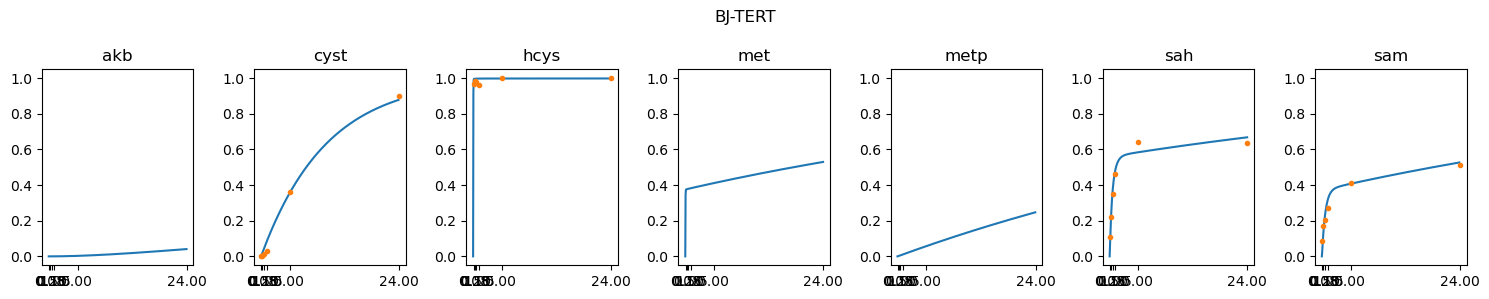

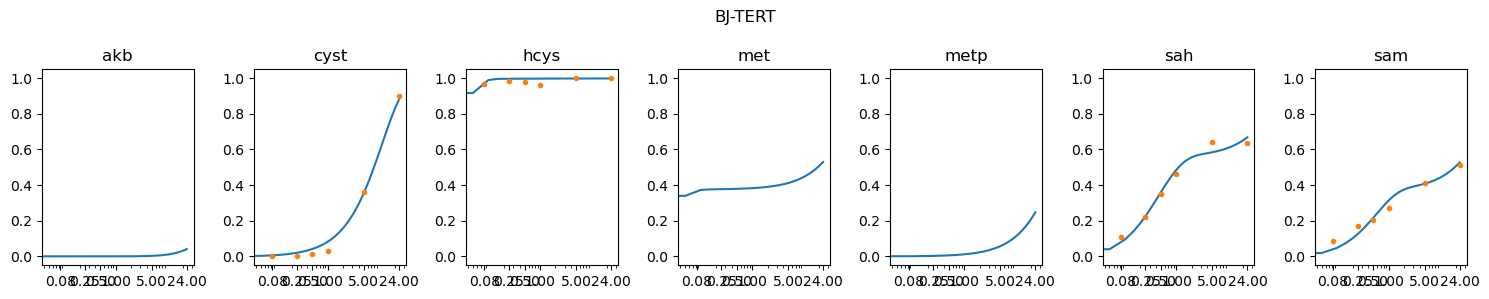

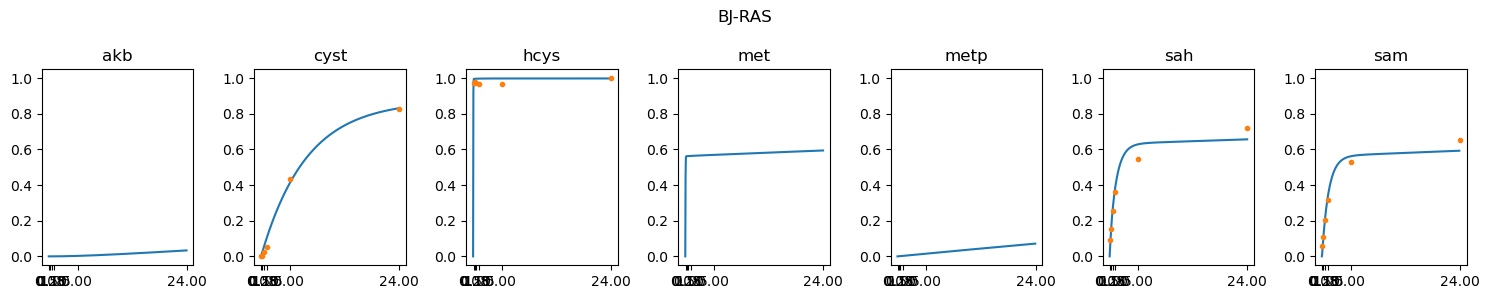

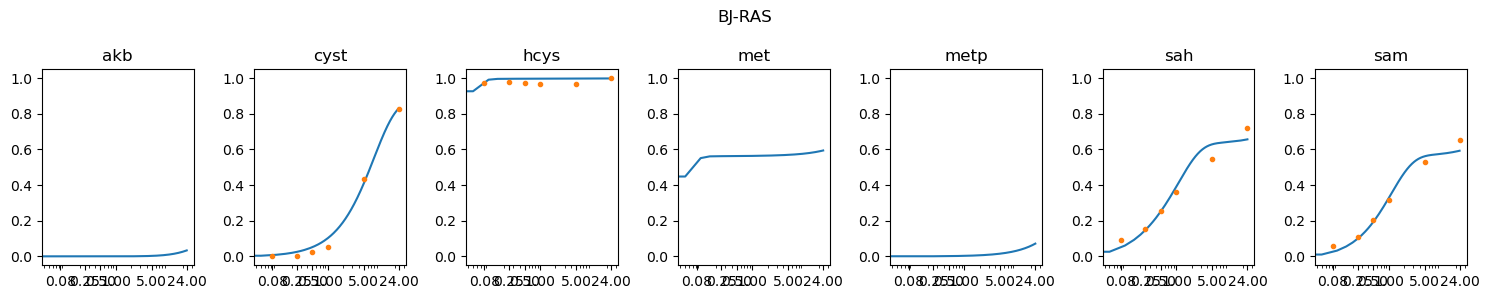

In [72]:
for cell_type in cell_types:
    for use_log_scale in [False, True]:
        plot_model_fit(
            flux_model, x_simulated.loc[cell_type], heavy_fraction_mean.loc[cell_type],
            use_log_scale=use_log_scale
        )
        plt.suptitle(cell_type)
        plt.tight_layout()
        plt.savefig(results_path / plot_file_name(cell_type, use_log_scale))

### Confidence intervals on estimated net fluxes
These are two-sided linearized confidence intervals, based on the parameter covariance from lmfit

In [33]:
ci_reactions = ['CYSTS', 'HCYS_IN', 'METS', 'MET_OUT', 'PROT_OUT', 'SAM_METH']
ci_table = pd.concat(
    [
        prepend_index_level(
            confidence_intervals_table(model_fits[cell_type], ci_level=0.9).loc[ci_reactions],
            cell_type, name='cell_type'
        )
        for cell_type in cell_types
    ]
)
ci_table

net    std err  ci_half-width    ci_lower  \
cell_type reaction                                                     
BJ-TERT   CYSTS       3.013415   0.822694       1.353211    1.660204   
          HCYS_IN   259.234312  73.514816     120.921111  138.313201   
          METS      272.924199  73.637354     121.122669  151.801531   
          MET_OUT    11.826440   6.317091      10.390690    1.435750   
          PROT_OUT  244.394457  73.448498     120.812028  123.582429   
          SAM_METH   16.703302   5.477582       9.009821    7.693480   
BJ-RAS    CYSTS       2.116578   0.375024       0.616859    1.499719   
          HCYS_IN    57.381173  10.021234      16.483463   40.897710   
          METS       87.798075  14.636554      24.074990   63.723085   
          MET_OUT     3.072406   1.983072       3.261864   -0.189458   
          PROT_OUT   52.192188   9.817897      16.149003   36.043185   
          SAM_METH   32.533481  10.612384      17.455818   15.077663   

                      ci_upper  
cell_type reaction              
BJ-TERT   CYSTS       4.366626  
          HCYS_IN   380.155424  
          METS      394.046868  
          MET_OUT    22.217130  
          PROT_OUT  365.206486  
          SAM_METH   25.713123  
BJ-RAS    CYSTS       2.733438  
          HCYS_IN    73.864636  
          METS      111.873064  
          MET_OUT     6.334270  
          PROT_OUT   68.341191  
          SAM_METH   49.989298

In [34]:
# since seaborn (strangely) does not support drawing error bars from specified values,
# we provide the (max, min) range as values and plot using median (midrange) and max/min for error bars
ci_table_for_seaborn = ci_table[['ci_lower', 'ci_upper']].melt(ignore_index=False).sort_index(ascending=[False, True]).reset_index()
ci_table_for_seaborn

,cell_type,reaction,variable,value
0,BJ-TERT,CYSTS,ci_lower,1.660204
1,BJ-TERT,CYSTS,ci_upper,4.366626
2,BJ-TERT,HCYS_IN,ci_lower,138.313201
3,BJ-TERT,HCYS_IN,ci_upper,380.155424
4,BJ-TERT,METS,ci_lower,151.801531
5,BJ-TERT,METS,ci_upper,394.046868
6,BJ-TERT,MET_OUT,ci_lower,1.435750
7,BJ-TERT,MET_OUT,ci_upper,22.217130
8,BJ-TERT,PROT_OUT,ci_lower,123.582429
9,BJ-TERT,PROT_OUT,ci_upper,365.206486


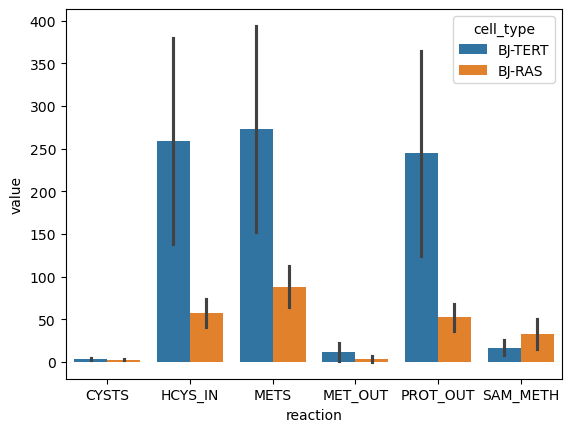

In [35]:
sns.barplot(
    ci_table_for_seaborn,
    x='reaction', y='value', hue='cell_type',
    estimator=np.median, errorbar=lambda x: [x.min(), x.max()]
)
plt.savefig(results_path / 'flux_ci.pdf')